# **Customer Churn Prediction and Retention Strategies**

## **WorkFlow of the Project**

<ul>
    <li>Data Loading</li>
    <li>Exploratory Data Analysis (E.D.A.)</li>
    <li>Data Preprocessing</li>
    <li>Machine Learning Model Developments</li>
    <li>Model Evaluation</li>
    <li>Conclusion</li>
</ul>

## Importing the Libraries

In [1]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library for Warning Message
import warnings
warnings.simplefilter("ignore")

# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Libraries for ML Parameters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV

# Libraries for ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Libraries for Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve

## Data Loading

In [3]:
# We have 2 separate datasets for training and test set.
df_train = pd.read_csv("customer_churn_dataset_training.csv")
df_test = pd.read_csv("customer_churn_dataset_testing.csv")

## Exploratory Data Analysis (E.D.A.)

Since we have separate datasets for training and testing, we will conduct Exploratory Data Analysis (EDA) on the training data, while the performance of the best machine learning models will be evaluated using the test data.

In [5]:
# Glimpse of the first 5 rows
print("Glimpse of the first 5 rows")
print(" ")
df_train.head()

Glimpse of the first 5 rows
 


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [7]:
# Converting the Column Names to "LowerCase"
df_train.columns = df_train.columns.str.lower()

# Verify
df_train.head(1)

,customerid,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0


In [9]:
# Setting the "customerid" column as Index
df_train = df_train.set_index("customerid")

# Verify
df_train.head(1)

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
customerid,,,,,,,,,,,
2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0


In [11]:
# Dimension of the Data
print("Dimension of the Data")
print(" ")
print("The dataset consists of {} rows and {} columns, with 'customerid' set as the index column.".format(
        df_train.shape[0], df_train.shape[1]+1))

Dimension of the Data
 
The dataset consists of 440833 rows and 12 columns, with 'customerid' set as the index column.


In [13]:
# Checking of Missing Values
print("Checking of Missing Values")
print(" ")

if df_train.isna().sum().sum() == 0:
    print("The data has no missing values")
else:
    print("The data has {} missing values in total.".format(df_train.isna().sum().sum()))

Checking of Missing Values
 
The data has 11 missing values in total.


In [15]:
# Verify which column(s) has missing values
df_train[df_train.isna().any(axis = 1)]

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
customerid,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Only 1 row has no data. Therefore, we can remove it from our dataset.

In [17]:
# Removing the missing row
df_train.dropna(inplace = True)

# Final Dimension
print("After removing the row with missing values, the final data consists of {} rows and {} columns (incl. index column).".format(
    df_train.shape[0], df_train.shape[1]+1))

After removing the row with missing values, the final data consists of 440832 rows and 12 columns (incl. index column).


### **Data Description**

**Customer Demographics:**
<ul>
    <li>Age</li>
    <li>Gender</li>
</ul>

**Engagement Metrics:**
<ul>
    <li>Tenure</li>
    <li>Usage Frequency</li>
    <li>Support Calls</li>
</ul>

**Payment Behavior:**
<ul>
    <li>Payment Delay</li>
    <li>Total Spend</li>
</ul>

**Subscription Details**
<ul>
    <li>Subscription Type</li>
    <li>Contract Length</li>
</ul>

**Customer Interaction:**
<ul>
    <li>Last Interaction</li>
</ul>

**Target Variable:**
<ul>
    <li>Churn (Binary indicator of whether a customer left)</li>
</ul>

In [19]:
# Check the Data Types of each variables
df_train.info()
print(" ")

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 2.0 to 449999.0
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                440832 non-null  float64
 1   gender             440832 non-null  object 
 2   tenure             440832 non-null  float64
 3   usage frequency    440832 non-null  float64
 4   support calls      440832 non-null  float64
 5   payment delay      440832 non-null  float64
 6   subscription type  440832 non-null  object 
 7   contract length    440832 non-null  object 
 8   total spend        440832 non-null  float64
 9   last interaction   440832 non-null  float64
 10  churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB
 


Now, columns like **age, tenure, support calls, churn, etc.** should be describe as integer and not as float.

In [21]:
# Convert the Numeric columns to integer

float_cols = ["age", "tenure", "usage frequency", "support calls", "payment delay", "last interaction", "churn"]

df_train[float_cols] = df_train[float_cols].astype("int")

In [23]:
# Convert the index to Integer
df_train.index = df_train.index.astype("int")

In [25]:
# Verify the Data Type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 2 to 449999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                440832 non-null  int64  
 1   gender             440832 non-null  object 
 2   tenure             440832 non-null  int64  
 3   usage frequency    440832 non-null  int64  
 4   support calls      440832 non-null  int64  
 5   payment delay      440832 non-null  int64  
 6   subscription type  440832 non-null  object 
 7   contract length    440832 non-null  object 
 8   total spend        440832 non-null  float64
 9   last interaction   440832 non-null  int64  
 10  churn              440832 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 40.4+ MB


In [27]:
# View the data
df_train.head()

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
customerid,,,,,,,,,,,
2,30,Female,39,14,5,18,Standard,Annual,932.0,17,1
3,65,Female,49,1,10,8,Basic,Monthly,557.0,6,1
4,55,Female,14,4,6,18,Basic,Quarterly,185.0,3,1
5,58,Male,38,21,7,7,Standard,Monthly,396.0,29,1
6,23,Male,32,20,5,8,Basic,Monthly,617.0,20,1


#### **Do we have Duplicate Customers?**

In [29]:
is_duplicate_customer = df_train.index.duplicated().any()

if is_duplicate_customer == True:
    print("There are duplicate customer present in the dataset.")
else:
    print("The dataset has no duplicate customers.")

The dataset has no duplicate customers.


In [31]:
# Check the unique values from Categorical Columns
print("Gender has {} unique values and they are {}.".format(df_train.gender.nunique(), df_train.gender.unique()))
print(" ")
print("Subscription Type has {} unique values and they are {}.".format(df_train["subscription type"].nunique(), df_train["subscription type"].unique()))
print(" ")
print("Contract Length has {} unique values and they are {}.".format(df_train["contract length"].nunique(), df_train["contract length"].unique()))

Gender has 2 unique values and they are ['Female' 'Male'].
 
Subscription Type has 3 unique values and they are ['Standard' 'Basic' 'Premium'].
 
Contract Length has 3 unique values and they are ['Annual' 'Monthly' 'Quarterly'].


<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='age', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of age')

<Axes: >

<Axes: xlabel='tenure', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of tenure')

<Axes: >

<Axes: xlabel='usage frequency', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of usage frequency')

<Axes: >

<Axes: xlabel='support calls', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of support calls')

<Axes: >

<Axes: xlabel='payment delay', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of payment delay')

<Axes: >

<Axes: xlabel='total spend', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of total spend')

<Axes: >

<Axes: xlabel='last interaction', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of last interaction')

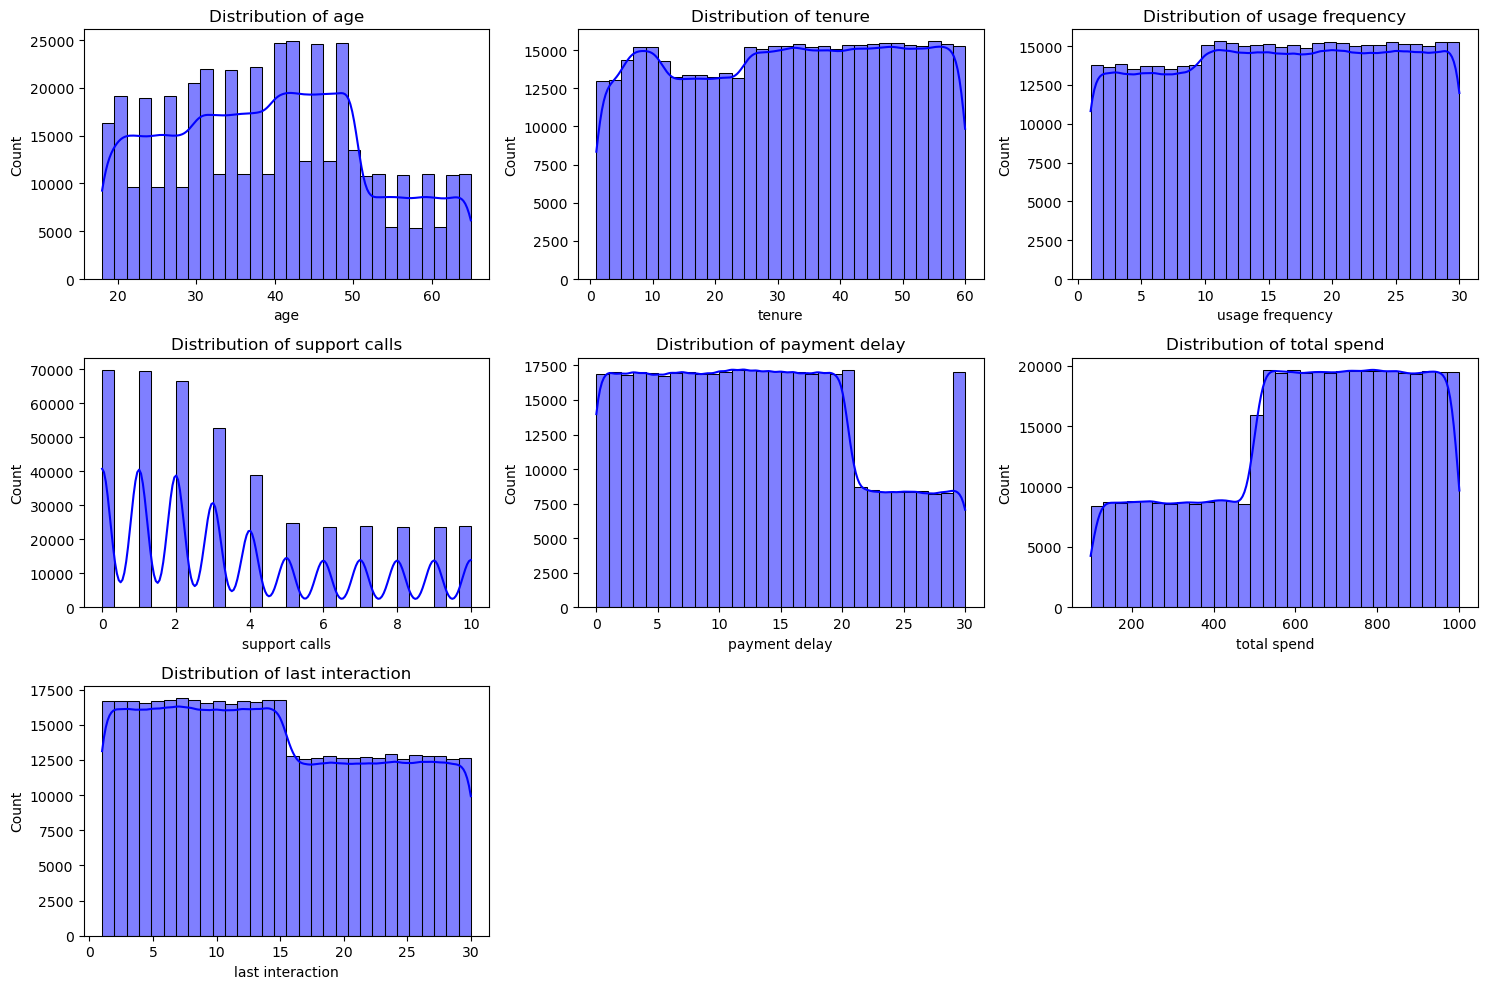

In [33]:
# Plot the distribution for numeric columns
col_num = ['age', 'tenure', 'usage frequency', 'support calls', 'payment delay', 'total spend', 'last interaction']


plt.figure(figsize=(15, 10))
for i, col in enumerate(col_num, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

<Axes: xlabel='subscription type', ylabel='count'>

Text(0.5, 1.0, 'Customer Churn Distribution by subscription type')

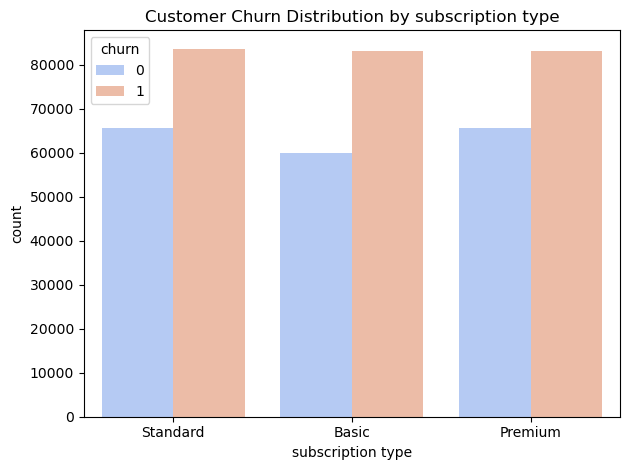

<Axes: xlabel='contract length', ylabel='count'>

Text(0.5, 1.0, 'Customer Churn Distribution by contract length')

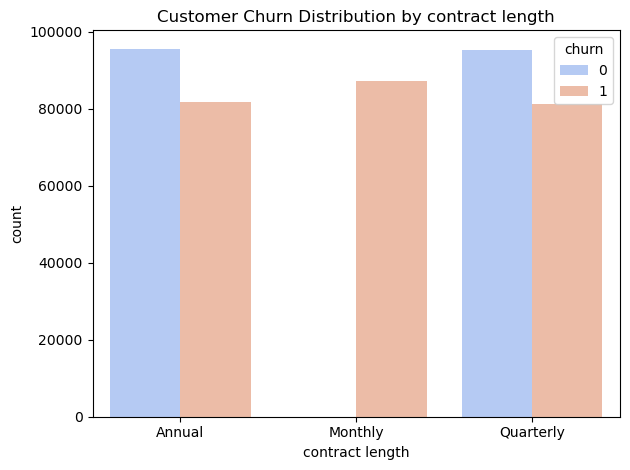

<Axes: xlabel='churn', ylabel='total spend'>

Text(0.5, 1.0, 'Average total spend between Churn Vs Not Churn Customers')

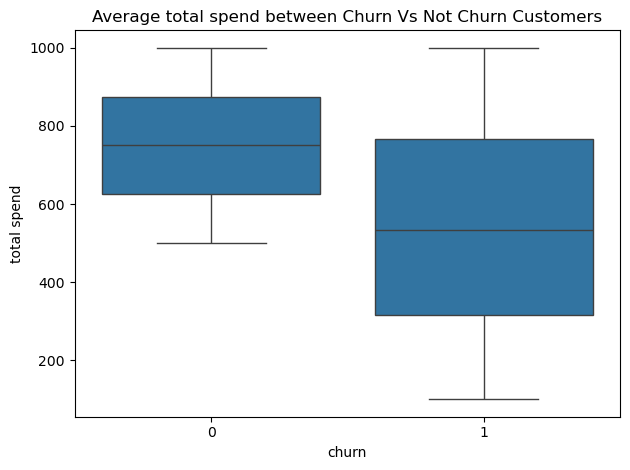

<Axes: xlabel='churn', ylabel='tenure'>

Text(0.5, 1.0, 'Average tenure between Churn Vs Not Churn Customers')

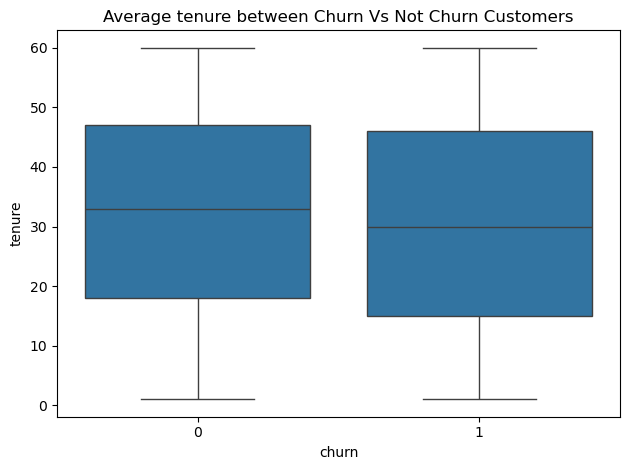

In [35]:
# [Subscription Type, Contract Length, Total Spend, Tenure] Vs Churn

compare_count = ["subscription type", "contract length"]
compare_box = ["total spend", "tenure"]

for col1 in compare_count:
    sns.countplot(x = col1, hue = "churn", data = df_train, palette = "coolwarm")
    plt.title(f"Customer Churn Distribution by {col1}")
    plt.tight_layout()
    plt.show()

for col2 in compare_box:
    sns.boxplot(x = "churn", y = col2, data = df_train)
    plt.title(f"Average {col2} between Churn Vs Not Churn Customers")
    plt.tight_layout()
    plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Payment Delays(Days)')

Text(0, 0.5, 'Probability of Churn')

Text(0.5, 1.0, 'Probability of Churn by Payment Delay')

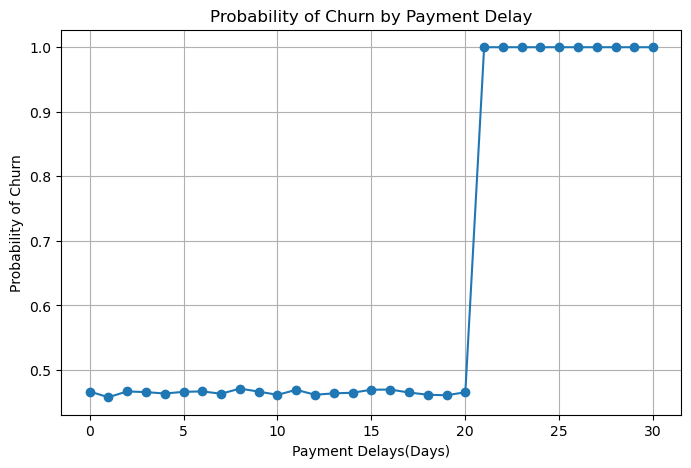

In [37]:
# Grouping by Payment Delay to calculate the Churn Probability
churn_prop = df_train.groupby("payment delay")["churn"].mean()

# Plot Churn Probability Vs Payment Delay
plt.figure(figsize = (8,5))
plt.plot(churn_prop.index, churn_prop.values, marker = "o", linestyle = "-")
plt.xlabel("Payment Delays(Days)")
plt.ylabel("Probability of Churn")
plt.title("Probability of Churn by Payment Delay")
plt.grid()
plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Support Calls')

Text(0, 0.5, 'Probability of Churn')

Text(0.5, 1.0, 'Probability of Churn by Support Calls')

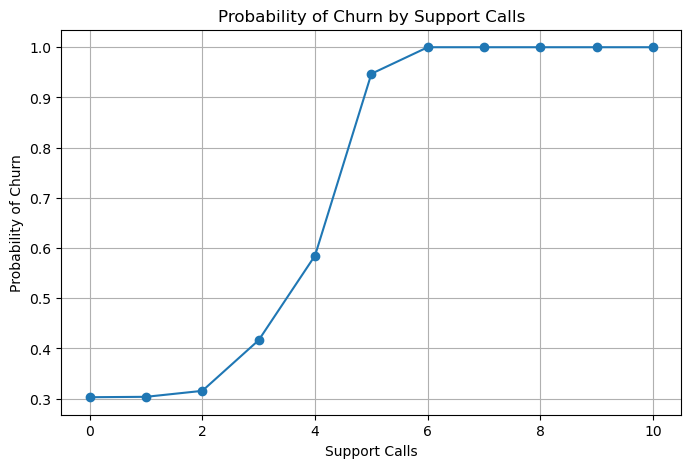

In [39]:
# Grouping by Support Calls to calculate churn propability
churn_prop_suppCalls = df_train.groupby("support calls")["churn"].mean()

# Plot Churn Probability Vs Support Calls
plt.figure(figsize = (8,5))
plt.plot(churn_prop_suppCalls.index, churn_prop_suppCalls.values, marker = "o", linestyle = "-")
plt.xlabel("Support Calls")
plt.ylabel("Probability of Churn")
plt.title("Probability of Churn by Support Calls")
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: >

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'tenure'),
  Text(2.5, 0, 'usage frequency'),
  Text(3.5, 0, 'support calls'),
  Text(4.5, 0, 'payment delay'),
  Text(5.5, 0, 'total spend'),
  Text(6.5, 0, 'last interaction'),
  Text(7.5, 0, 'churn')])

Text(0.5, 1.0, 'Correlation Between Numeric Columns Vs Churn')

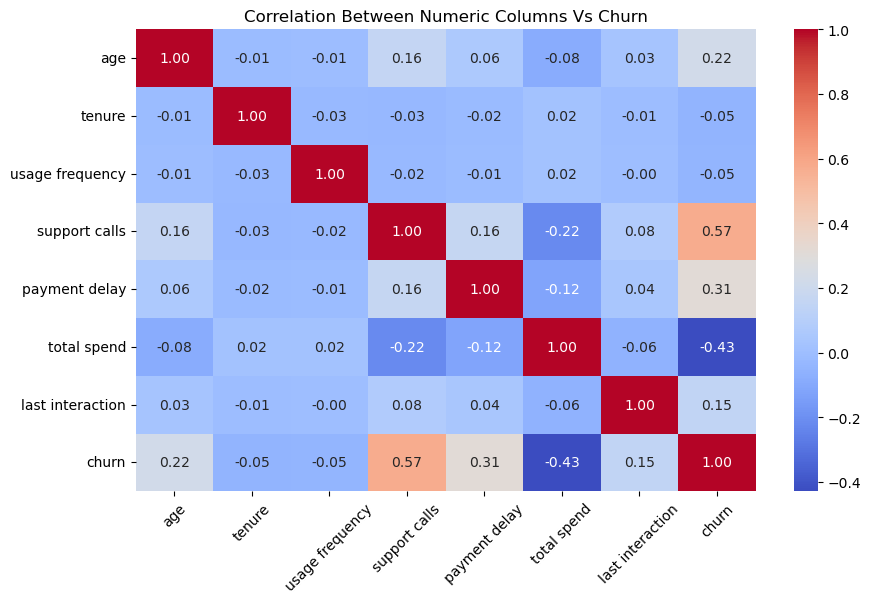

In [41]:
# Correlation between Numeric Columns
plt.figure(figsize = (10,6))
sns.heatmap(df_train.corr(numeric_only = True), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.xticks(rotation = 45)
plt.title("Correlation Between Numeric Columns Vs Churn")
plt.show()

### **Age Group Segmentation**

In [43]:
print("Minimum Age: {}".format(df_train.age.min()))
print("Maximum Age: {}".format(df_train.age.max()))

Minimum Age: 18
Maximum Age: 65


<ul>
    <li>Young Adults: 18 - 24 years</li>
    <li>Young Professionals: 25 - 34 years</li>
    <li>Established Adults: 35 - 44 years</li>
    <li>Middle-Aged Consumers: 45 - 54 years</li>
    <li>Seniors: 55 - 65 years</li>
</ul>

In [45]:
def age_segmentation(age):
    if age < 18:
        return "Minors"
    elif 18 <= age <= 24:
        return "Young Adults"
    elif 25 <= age <= 34:
        return "Young Professionals"
    elif 35 <= age <= 44:
        return "Established Adults"
    elif 45 <= age <= 54:
        return "Middle-Aged Consumers"
    else:
        return "Seniors"


df_train["age group"] = df_train.age.apply(age_segmentation)
cols = list(df_train.columns)
df_train = df_train[cols[:-2] + [cols[-1], cols[-2]]]
df_train.head()

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,age group,churn
customerid,,,,,,,,,,,,
2,30,Female,39,14,5,18,Standard,Annual,932.0,17,Young Professionals,1
3,65,Female,49,1,10,8,Basic,Monthly,557.0,6,Seniors,1
4,55,Female,14,4,6,18,Basic,Quarterly,185.0,3,Seniors,1
5,58,Male,38,21,7,7,Standard,Monthly,396.0,29,Seniors,1
6,23,Male,32,20,5,8,Basic,Monthly,617.0,20,Young Adults,1


<Axes: xlabel='age group', ylabel='count'>

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Young Professionals'),
  Text(1, 0, 'Seniors'),
  Text(2, 0, 'Young Adults'),
  Text(3, 0, 'Middle-Aged Consumers'),
  Text(4, 0, 'Established Adults')])

Text(0.5, 1.0, 'Customer Churn Distribution by Age Group')

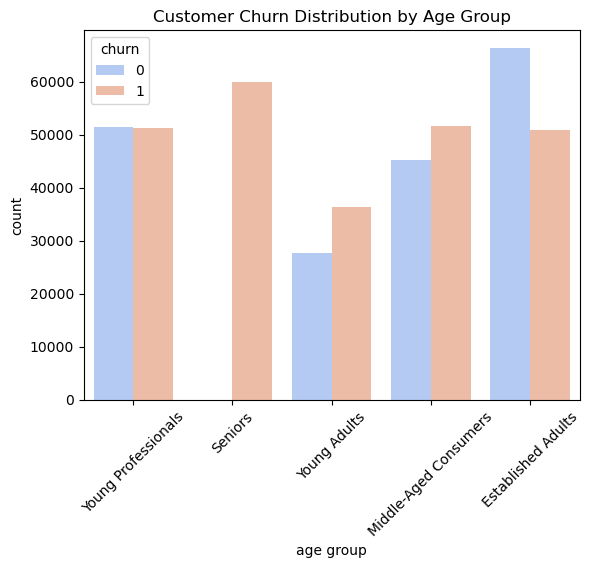

In [47]:
# Plot Customer Segmentation based on Age
sns.countplot(x = "age group", hue = "churn", data = df_train, palette = "coolwarm")
plt.xticks(rotation = 45)
plt.title("Customer Churn Distribution by Age Group")
plt.show()

<Axes: xlabel='gender', ylabel='count'>

([0, 1], [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

Text(0.5, 1.0, 'Customer Churn Distribution by Gender')

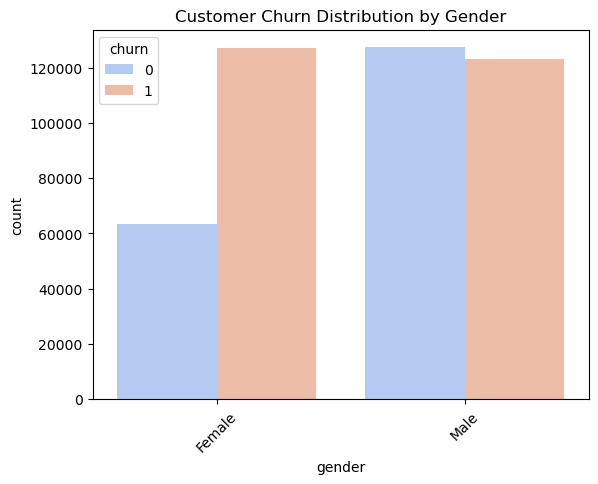

In [49]:
# Plot Customer Segmentation based on Gender
sns.countplot(x = "gender", hue = "churn", data = df_train, palette = "coolwarm")
plt.xticks(rotation = 45)
plt.title("Customer Churn Distribution by Gender")
plt.show()

## Data Preprocessing

**Splitting the Data**

In [51]:
# Storing the Train and Test set in separate Data Frames
train_df = df_train.copy().drop(columns = ["age group"])
test_df = df_test.copy()

# Modify the Column Names
test_df.columns = test_df.columns.str.lower()

# Setting the 'customerid column' as index
test_df = test_df.set_index("customerid")

In [53]:
# Pre-Processing Categorical Columns
categorical_features = ["gender", "subscription type", "contract length"]

train_df = pd.get_dummies(train_df, columns = categorical_features, drop_first = True)
test_df = pd.get_dummies(test_df, columns = categorical_features, drop_first = True)

# Separate Features and Target Variables
# 1. Training Set
X_train = train_df.drop(columns = ["churn"])
y_train = train_df["churn"]

# 2. Test Set
X_test = test_df.drop(columns = ["churn"])
y_test = test_df["churn"]

**Handle Class Imbalance using SMOTE.**

In [55]:
smote = SMOTE(random_state = 42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Compute Sample Weights for Class Imbalance
sample_weights = compute_sample_weight(
                                        class_weight = "balanced",
                                        y = y_train_balanced)

<Figure size 1200x600 with 0 Axes>

<Axes: >

([<matplotlib.patches.Wedge at 0x155f57f50>,
 [Text(-1.075644810680109, -0.23019174888981714, '1'),
  Text(1.075644810680109, 0.230191748889817, '0')],
 [Text(-0.5867153512800594, -0.12555913575808206, '56.7%'),
  Text(0.5867153512800594, 0.125559135758082, '43.3%')])

Text(0.5, 1.0, 'Original Class Distribution')

<Axes: >

([<matplotlib.patches.Wedge at 0x1479f7a40>,
 [Text(-1.1, 1.3471114790620887e-16, '1'),
  Text(1.1, -2.6942229581241775e-16, '0')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.6, -1.4695761589768238e-16, '50.0%')])

Text(0.5, 1.0, 'Balanced Class Distribution')

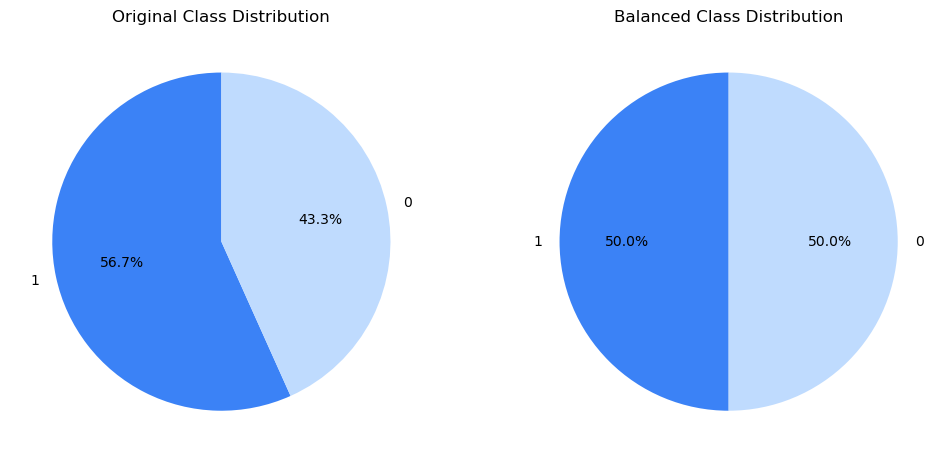

In [57]:
# Before SMOTE (Original Class Distribution)
original_class = Counter(y_train)

# After SMOTE (Balanced Class Distribution)
balanced_class = Counter(y_train_balanced)

# Plot the Original Class Distribution
plt.figure(figsize = (12,6))

# Subplot for Original Class Distribution
plt.subplot(1, 2, 1)
plt.pie(original_class.values(), labels = original_class.keys(), autopct = '%1.1f%%', startangle = 90, colors = ['#3B82F6', '#BFDBFE'])
plt.title("Original Class Distribution")

# Subplot for Balanced Class Distribution
plt.subplot(1, 2, 2)
plt.pie(balanced_class.values(), labels = balanced_class.keys(), autopct = '%1.1f%%', startangle = 90, colors = ['#3B82F6', '#BFDBFE'])
plt.title("Balanced Class Distribution")

# Show the Plot
plt.show()

**Normalizing the Data for ***Logistic Regression*** and ***MLP*** Models**

In [59]:
# Method to Scale
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Model Development & Model Evaluation

<ul>
    <li>Logistic Regression</li>
    <li>Decision Tree</li>
    <li>Gradient Boosting</li>
    <li>Multi Layer Perceptron (MLP)</li>
</ul>

### **Logistic Regression**

#### **Baseline Model**

(a) Initializing the Model

In [61]:
# Initialize Baseline Logistic Regression Model
logreg_baseM = LogisticRegression()

# Fit the Model
logreg_baseM.fit(X_train_scaled, y_train_balanced)

LogisticRegression()

(b) Evaluating the Model

**Precision:**
<ul>
    <li>Out of all the predicted positives, how many are actually positive</li>
    <li>Precision = TP / (TP + FP)</li>
    <li>High Precision means few False Positives</li>
</ul>

**Recall:**
<ul>
    <li>Out of all actual positives, how many did the model correctly identify</li>
    <li>Recall = TP / (TP + FN)</li>
    <li>High Recall means few False Negatives</li>
</ul>

**F1 Score**
<ul>
    <li>Harmonic mean of precision and recall. Balances both.</li>
    <li>F1-Score = 2 * [(Precision * Recall) / (Precision + Recall)]</li>
    <li>Used when you want a balance between precision and recall</li>
</ul>

**Confusion Matrix**
<ul>
    <li>True Positive (TP): Model correctly predicted positive class</li>
    <li>True Negative (TN): Model correctly predicted negative class</li>
    <li>False Positive (FP): Model incorrectly predicted the negative class as postive (Type 1 Error)</li>
    <li>False Negative (FN): Model incorrectly predicted the positive class as negative (Type 2 Error)</li>
</ul>

In [63]:
# Logistic Regression - Model Evaluation on Training Set

# Prediction on Training Set
logreg_baseM_y_train_pred = logreg_baseM.predict(X_train_scaled)

# Accuracy on Training Set
logreg_baseM_train_acc = accuracy_score(y_train_balanced, logreg_baseM_y_train_pred)

# Classification Report of Training Set
logreg_baseM_train_CR = classification_report(y_train_balanced, logreg_baseM_y_train_pred)

# Print the Result of Training Set
print("Logistic Regression Baseline Model Result on Training Data")
print(" ")
print("Logistic Regression Baseline Model Accuracy (Training Set): {}".format(logreg_baseM_train_acc))
print(" ")
print("Logistic Regression Baseline Model Classification Report (Training Set): \n", logreg_baseM_train_CR)

Logistic Regression Baseline Model Result on Training Data
 
Logistic Regression Baseline Model Accuracy (Training Set): 0.9048616194464778
 
Logistic Regression Baseline Model Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91    249999
           1       0.93      0.88      0.90    249999

    accuracy                           0.90    499998
   macro avg       0.91      0.90      0.90    499998
weighted avg       0.91      0.90      0.90    499998



In [65]:
# Logistics Regression - Model Evaluation on Test Set

# Prediction on Test Set
logreg_baseM_y_test_pred = logreg_baseM.predict(X_test_scaled)

# Accuracy on Test Set
logreg_baseM_test_acc = accuracy_score(y_test, logreg_baseM_y_test_pred)

# Classification Report of Test Set
logreg_baseM_test_CR = classification_report(y_test, logreg_baseM_y_test_pred)

# Print the Result of Test Set
print("Logistic Regression Baseline Model Result on Test Data")
print(" ")
print("Logistic Regression Baseline Model Accuracy (Test Set): {}".format(logreg_baseM_test_acc))
print(" ")
print("Logistic Regression Baseline Model Classification Report (Test Set): \n", " ", logreg_baseM_test_CR)

Logistic Regression Baseline Model Result on Test Data
 
Logistic Regression Baseline Model Accuracy (Test Set): 0.5762730294839532
 
Logistic Regression Baseline Model Classification Report (Test Set): 
                 precision    recall  f1-score   support

           0       0.95      0.21      0.34     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.51     64374
weighted avg       0.75      0.58      0.50     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Logistic Regression Baseline Model')

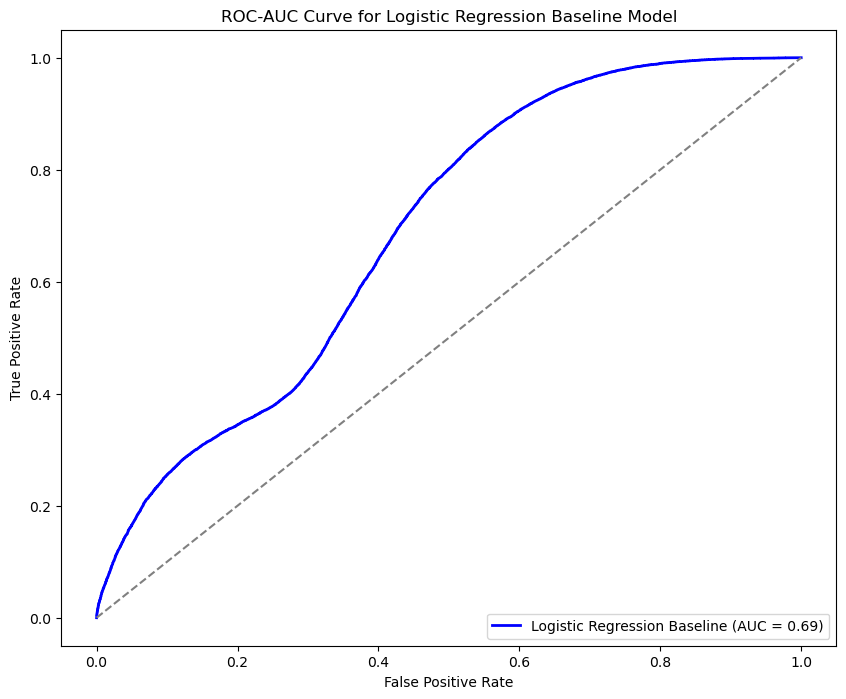

In [68]:
logreg_baseM_y_prob = logreg_baseM.predict_proba(X_test_scaled)[:,1]

logreg_baseM_fpr, logreg_baseM_tpr, _ = roc_curve(y_test, logreg_baseM_y_prob)

logreg_baseM_auc = auc(logreg_baseM_fpr, logreg_baseM_tpr)

# Plot the ROC - AUC Curve of Logistic Regression
plt.figure(figsize = (10,8))
plt.plot(logreg_baseM_fpr, logreg_baseM_tpr, label = f"Logistic Regression Baseline (AUC = {logreg_baseM_auc:.2f})", color = "blue", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Logistic Regression Baseline Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [73]:
# Confusion Matrix for Test Set of Logistic Regression
logreg_baseM_test_CM = confusion_matrix(y_test, logreg_baseM_y_test_pred)

# Print the Extracted Values
logreg_baseM_TN, logreg_baseM_FP, logreg_baseM_FN, logreg_baseM_TP = logreg_baseM_test_CM.ravel()

print("Confusion Matrix for Logistic Regression Baseline Model")
print(" ")
print("True Positives (TP): {}".format(logreg_baseM_TP))
print(" ")
print("False Positives (FP): {}".format(logreg_baseM_FP))
print(" ")
print("True Negatives (TN): {}".format(logreg_baseM_TN))
print(" ")
print("False Negatives (FN): {}".format(logreg_baseM_FN))

Confusion Matrix for Logistic Regression Baseline Model
 
True Positives (TP): 30143
 
False Positives (FP): 26927
 
True Negatives (TN): 6954
 
False Negatives (FN): 350


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Baseline Model')

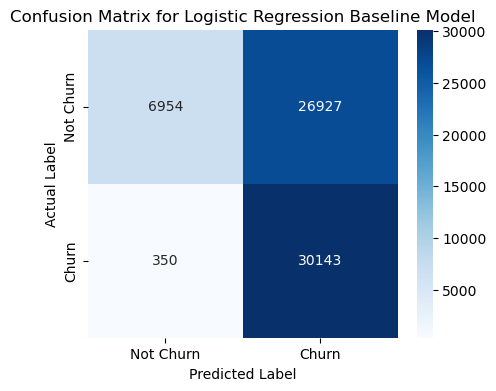

In [87]:
# Plot the Confusion Matrix for Test Set of Logistic Regression
plt.figure(figsize = (5,4))
sns.heatmap(logreg_baseM_test_CM, annot = True, fmt = 'd', cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Logistic Regression Baseline Model")
plt.show()

#### **Interpretation of Logistic Regression Baseline Model**

**Training Set**
<ul>
    <li>Performs very well across all the metrics</li>
    <li>Both classes are well-learned</li>
    <li>Indicates possible overfitting, especially given test performance</li>
</ul>

**Test Set**
<ul>
    <li>Accuracy plummets to 58%</li>
    <li>The precision of 53% on the test set suggests that nearly half of the positive predictions are incorrect, leading to a high false positive rate</li>
    <li>The recall is extremely high at 99%, indicating that the model identifies almost all positive cases but at the cost of misclassifying many negative cases as positive</li>
</ul>

**Root Cause Analysis**
<ul>
    <li>Overfitting: Model learned training data too tightly</li>
    <li>Generalization Failure: Poor on unseen data</li>
</ul>

**Next Steps to Improve**
<ul>
    <li>Adding of Regularization, adjusting "C" and solvers</li>
</ul>

#### **Tuning the Model**

**Experiment 1**
<ul>
    <li>Regularization (Penalty): ['l1', 'l2']</li>
    <li>Regularization Strength (C): [0.001, 0.01, 0.1, 1]</li>
    <li>Solver: ['saga', 'lbfgs']</li>
</ul>

(a) Initializing the Model

In [98]:
# Initialize Logistic Regression Model with Experiment 1
logreg_E1 = LogisticRegression(max_iter = 1000)

# Define the hyperparameter 1
logreg_E1_param = {
                    'penalty' : ['l1', 'l2'],
                    'C' : [0.001, 0.01, 0.1, 1],
                    'solver' : ['saga', 'lbfgs']
                  }

# Grid Search Cross Validation
logreg_E1_grid = GridSearchCV(logreg_E1, param_grid = logreg_E1_param, cv = 5, scoring = "accuracy", n_jobs = -1, return_train_score = True)

# Fit the Logistic Regression Model
logreg_E1_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'lbfgs']},
             return_train_score=True, scoring='accuracy')

(b) Best Parameter and Best Model

In [101]:
# Best Parameter of Logistic Regression Model (Experiment 1)
logreg_E1_best_param = logreg_E1_grid.best_params_
print("Best Parameter of Logistic Regression Model (Experiment 1): {}".format(logreg_E1_best_param))

# Best Model of Logistic Regression Model (Experiment 1)
logreg_E1_best_model = logreg_E1_grid.best_estimator_

Best Parameter of Logistic Regression Model (Experiment 1): {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


(c) Evaluating the Model

In [112]:
# Logistic Regression (Experiment 1) - Model Evaluation on Training Set

# Prediction on Training Set
logreg_E1_y_train_pred = logreg_E1_best_model.predict(X_train_scaled)

# Accuracy on Training Set
logreg_E1_train_acc = accuracy_score(y_train_balanced, logreg_E1_y_train_pred)

# Classification Report of Training Set
logreg_E1_train_CR = classification_report(y_train_balanced, logreg_E1_y_train_pred)

# Print the Result of Training Set
print("Logistic Regression (Experiment 1) Result on Training Data")
print(" ")
print("Logistic Regression (Experiment 1) Accuracy (Training Set): {}".format(logreg_E1_train_acc))
print(" ")
print("Logistic Regression (Experiment 1) Classification Report (Training Set):\n", logreg_E1_train_CR)

Logistic Regression (Experiment 1) Result on Training Data
 
Logistic Regression (Experiment 1) Accuracy (Training Set): 0.9052176208704835
 
Logistic Regression (Experiment 1) Classification Report (Training Set):
               precision    recall  f1-score   support

           0       0.88      0.93      0.91    249999
           1       0.93      0.88      0.90    249999

    accuracy                           0.91    499998
   macro avg       0.91      0.91      0.91    499998
weighted avg       0.91      0.91      0.91    499998



In [114]:
# Logistic Regression (Experiment 1) - Model Evaluation on Test Set

# Prediction on Test Set
logreg_E1_y_test_pred = logreg_E1_best_model.predict(X_test_scaled)

# Accuracy on Test Set
logreg_E1_test_acc = accuracy_score(y_test, logreg_E1_y_test_pred)

# Classification Report of Test Set
logreg_E1_test_CR = classification_report(y_test, logreg_E1_y_test_pred)

# Print the Result of Test Set
print("Logistic Regression (Experiment 1) Result on Test Data")
print(" ")
print("Logistic Regression (Experiment 1) Accuracy (Test Set): {}".format(logreg_E1_test_acc))
print(" ")
print("Logistic Regression (Experiment 1) Classification Report (Test Set):\n", logreg_E1_test_CR)

Logistic Regression (Experiment 1) Result on Test Data
 
Logistic Regression (Experiment 1) Accuracy (Test Set): 0.5779041227824898
 
Logistic Regression (Experiment 1) Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.95      0.21      0.34     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.52     64374
weighted avg       0.75      0.58      0.51     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Logistic Regression (Experiment 1) Model')

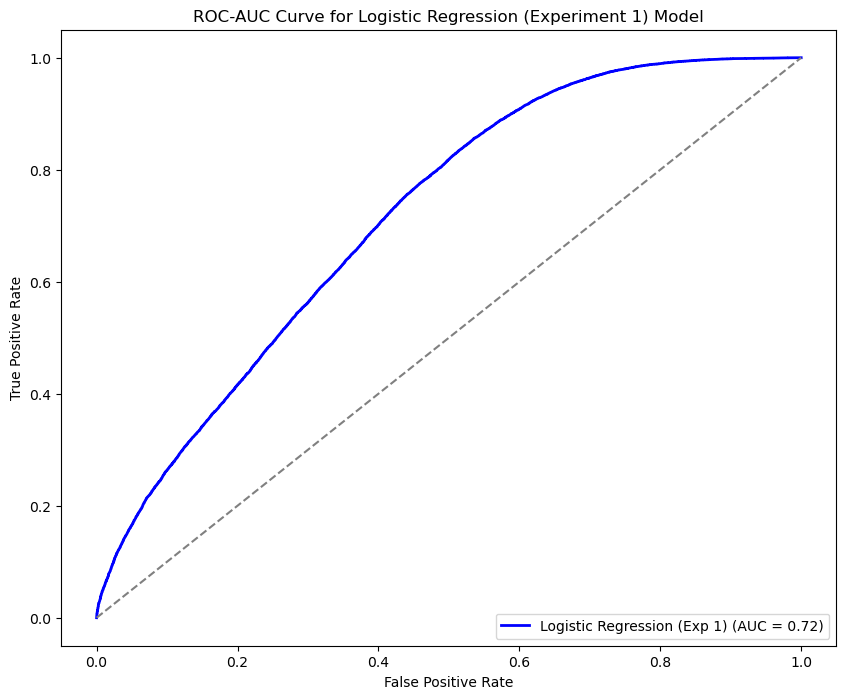

In [116]:
logreg_E1_y_prob = logreg_E1_best_model.predict_proba(X_test_scaled)[:,1]

logreg_E1_fpr, logreg_E1_tpr, _ = roc_curve(y_test, logreg_E1_y_prob)

logreg_E1_auc = auc(logreg_E1_fpr, logreg_E1_tpr)

# Plot the ROC - AUC Curve of Logistic Regression
plt.figure(figsize = (10,8))
plt.plot(logreg_E1_fpr, logreg_E1_tpr, label = f"Logistic Regression (Exp 1) (AUC = {logreg_E1_auc:.2f})", color = "blue", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Logistic Regression (Experiment 1) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [118]:
# Confusion Matrix for Test Set of Logistic Regression (Experiment 1)
logreg_E1_test_CM = confusion_matrix(y_test, logreg_E1_y_test_pred)

# Print the Extracted Values
logreg_E1_TN, logreg_E1_FP, logreg_E1_FN, logreg_E1_TP = logreg_E1_test_CM.ravel()

print("Confusion Matrix for Logistic Regression (Experiment 1)")
print(" ")
print("True Positives (TP): {}".format(logreg_E1_TP))
print(" ")
print("False Positives (FP): {}".format(logreg_E1_FP))
print(" ")
print("True Negatives (TN): {}".format(logreg_E1_TN))
print(" ")
print("False Negatives (FN): {}".format(logreg_E1_FN))

Confusion Matrix for Logistic Regression (Experiment 1)
 
True Positives (TP): 30140
 
False Positives (FP): 26819
 
True Negatives (TN): 7062
 
False Negatives (FN): 353


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression (Experiment 1)')

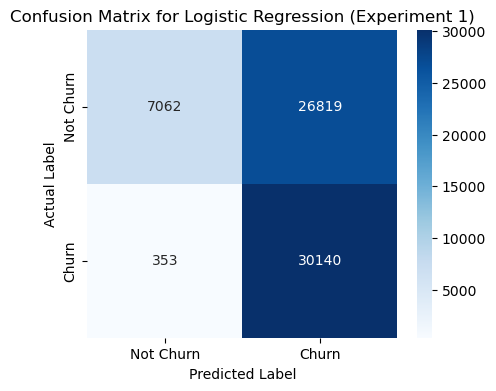

In [120]:
# Plot the Confusion Matrix for Test Set of Logistic Regression (Experiment 1)
plt.figure(figsize = (5,4))
sns.heatmap(logreg_E1_test_CM, annot = True, fmt = 'd', cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Logistic Regression (Experiment 1)")
plt.show()

**Experiment 2**
<ul>
    <li>Regularization (Penalty): ['l1', 'l2']</li>
    <li><font color = "blue">Regularization Strength (C): [0.000001,0.00001,0.0001,0.001]</font></li>
    <li>Solver: ['saga', 'lbfgs']</li>
</ul>

(a) Initializing the Model

In [126]:
# Initialize Logistic Regression Model with Experiment 2
logreg_E2 = LogisticRegression(max_iter = 1000)

# Define the hyperparameter 2
logreg_E2_param = {
                    'penalty' : ['l1', 'l2'],
                    'C' : [0.000001,0.00001,0.0001,0.001],
                    'solver' : ['saga', 'lbfgs']
                  }

# Grid Search Cross Validation
logreg_E2_grid = GridSearchCV(logreg_E2, param_grid = logreg_E2_param, cv = 5, scoring = "accuracy", n_jobs = -1, return_train_score = True)

# Fit the Logistic Regression Model
logreg_E2_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001],
                         'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs']},
             return_train_score=True, scoring='accuracy')

(b) Best Parameter and Best Model

In [129]:
# Best Parameter of Logistic Regression Model (Experiment 2)
logreg_E2_best_param = logreg_E2_grid.best_params_
print("Best Parameter of Logistic Regression Model (Experiment 2): {}".format(logreg_E2_best_param))

# Best Model of Logistic Regression Model (Experiment 2)
logreg_E2_best_model = logreg_E2_grid.best_estimator_

Best Parameter of Logistic Regression Model (Experiment 2): {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


In [131]:
if logreg_E1_best_param == logreg_E2_best_param:
    print("Same Result")
else:
    print("Different Result")

Same Result


#### **Conclusions**

Even after reducing the regularization strength (C value), the model continued to select the same parameters as in Experiment 1. Furthermore, tuning the logistic regression model did not lead to any significant improvement in performance metrics. Therefore, the next logical step is to explore more advanced models, such as **Decision Trees**.

### **Decision Tree**

#### **Baseline Model**

(a) Initializing the Model

In [150]:
# Initialize Baseline Decision Tree Model
dectree_baseM = DecisionTreeClassifier()

# Fit the Model
dectree_baseM.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier()

(b) Evaluating the Model

In [153]:
# Decision Tree - Model Evaluation on Training Set

# Prediction on Training Set
dectree_baseM_y_train_pred = dectree_baseM.predict(X_train_balanced)

# Accuracy of Training Set
dectree_baseM_train_acc = accuracy_score(y_train_balanced, dectree_baseM_y_train_pred)

# Classification Report of Training Set
dectree_baseM_train_CR = classification_report(y_train_balanced, dectree_baseM_y_train_pred)

# Print the Result of Training Set
print("Decision Tree Baseline Model Result on Training Data")
print(" ")
print("Decision Tree Baseline Model Accuracy (Training Set): {}".format(dectree_baseM_train_acc))
print(" ")
print("Decision Tree Baseline Model Classification Report (Training Set): \n", dectree_baseM_train_CR)

Decision Tree Baseline Model Result on Training Data
 
Decision Tree Baseline Model Accuracy (Training Set): 1.0
 
Decision Tree Baseline Model Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    249999
           1       1.00      1.00      1.00    249999

    accuracy                           1.00    499998
   macro avg       1.00      1.00      1.00    499998
weighted avg       1.00      1.00      1.00    499998



In [155]:
# Decision Tree - Model Evaluation on Test Set

# Prediction on Test Set
dectree_baseM_y_test_pred = dectree_baseM.predict(X_test)

# Accuracy of Test Set
dectree_baseM_test_acc = accuracy_score(y_test, dectree_baseM_y_test_pred)

# Classification Report of Test Set
dectree_baseM_test_CR = classification_report(y_test, dectree_baseM_y_test_pred)

# Print the Result of Test Set
print("Decision Tree Baseline Model Result on Test Data")
print(" ")
print("Decision Tree Baseline Model Accuracy (Test Set): {}".format(dectree_baseM_test_acc))
print(" ")
print("Decision Tree Baseline Model Classification Report (Test Set): \n", dectree_baseM_test_CR)

Decision Tree Baseline Model Result on Test Data
 
Decision Tree Baseline Model Accuracy (Test Set): 0.5033864603721999
 
Decision Tree Baseline Model Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Decision Tree Baseline Model')

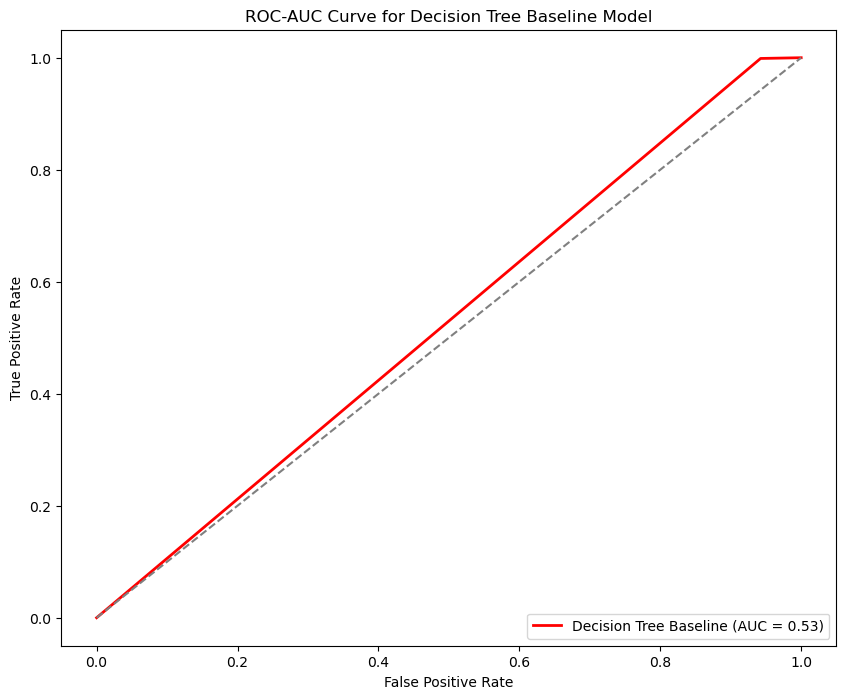

In [158]:
dectree_baseM_y_prob = dectree_baseM.predict_proba(X_test)[:,1]

dectree_baseM_fpr, dectree_baseM_tpr, _ = roc_curve(y_test, dectree_baseM_y_prob)

dectree_baseM_auc = auc(dectree_baseM_fpr, dectree_baseM_tpr)

# Plot the ROC - AUC Curve of Decision Tree
plt.figure(figsize = (10,8))
plt.plot(dectree_baseM_fpr, dectree_baseM_tpr, label = f"Decision Tree Baseline (AUC = {dectree_baseM_auc:.2f})", color = "red", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Decision Tree Baseline Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [162]:
# Confusion Matrix for Test Set of Decision Tree
dectree_baseM_test_CM = confusion_matrix(y_test, dectree_baseM_y_test_pred)

# Print the Extracted Values
dectree_baseM_TN, dectree_baseM_FP, dectree_baseM_FN, dectree_baseM_TP = dectree_baseM_test_CM.ravel()

print("Confusion Matrix for Decision Tree Baseline Model")
print(" ")
print("True Positives (TP): {}".format(dectree_baseM_TP))
print(" ")
print("False Positives (FP): {}".format(dectree_baseM_FP))
print(" ")
print("True Negatives (TN): {}".format(dectree_baseM_TN))
print(" ")
print("False Negatives (FN): {}".format(dectree_baseM_FN))

Confusion Matrix for Decision Tree Baseline Model
 
True Positives (TP): 30453
 
False Positives (FP): 31929
 
True Negatives (TN): 1952
 
False Negatives (FN): 40


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree Baseline Model')

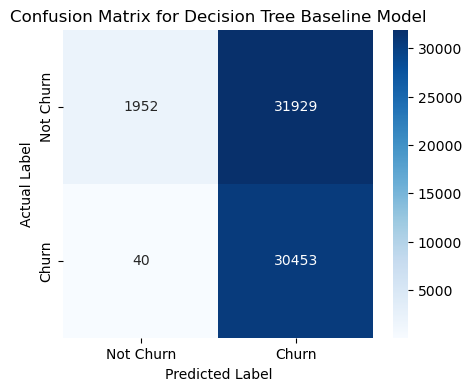

In [164]:
# Plot the Confusion Matrix for Test Set of Decision Tree
plt.figure(figsize = (5,4))
sns.heatmap(dectree_baseM_test_CM, annot = True, fmt = 'd', cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Decision Tree Baseline Model")
plt.show()